# OpenML CC18 Metalearning Benchmark

In [1]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import pandera as pa
import plotly.express as px
import seaborn as sns

## Load Data

In [3]:
JOB = 323


check_betw_zero_one = pa.Check(lambda s: (0.0 <= s) & (s <= 1.0))

INFERENCE_RESULT_SCHEMA = pa.DataFrameSchema(
    columns={
        "data_env": pa.Column(pa.String),
        "n_inference_steps": pa.Column(pa.Int),
        "is_valid": pa.Column(pa.Bool),
        "reward": pa.Column(pa.Float),
        "validation_score": pa.Column(pa.Float),
    },
    coerce=True,
)

@pa.check_output(INFERENCE_RESULT_SCHEMA)
def data_to_longform(inference_results):
    return (
        inference_results
        [["data_env", "n_inference_steps", "key", "value"]]
        .dropna(subset=["value"])
        .pivot_table(
            index=["data_env", "n_inference_steps"],
            columns="key",
            values="value",
            aggfunc=lambda x: x,
        )
        .reset_index()
        .dropna()
        # all scores should be strings
        .loc[
            lambda df: (
                df.validation_score.map(lambda x: isinstance(x, str)) &
                df.mlf.map(lambda x: isinstance(x, str)) &
                df.reward.map(lambda x: isinstance(x, str)) &
                df.is_valid.map(lambda x: isinstance(x, str))
            )
        ]
        .rename_axis(None, axis=1)
        .reset_index(drop=True)
    )

In [4]:
inference_results = pd.concat([
    (
        pd.read_csv(f"../floyd_outputs/{JOB}/{env}_env_inference_results.csv")
        .pipe(data_to_longform)
        .assign(data_env_partition=env)
    ) for env in ["training", "test"]
])
inference_results.head()

,data_env,n_inference_steps,is_valid,mlf,mlf_full,reward,scorer,target_type,validation_score,data_env_partition
0,openml.2dplanes,0,True,SimpleImputer > OneHotEncoder > StandardScaler...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.982218,roc_auc,TargetType.BINARY,0.982218,training
1,openml.2dplanes,1,True,SimpleImputer > OneHotEncoder > StandardScaler...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.983409,roc_auc,TargetType.BINARY,0.983409,training
2,openml.2dplanes,2,True,SimpleImputer > OneHotEncoder > StandardScaler...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.986829,roc_auc,TargetType.BINARY,0.986829,training
3,openml.2dplanes,3,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.984914,roc_auc,TargetType.BINARY,0.984914,training
4,openml.2dplanes,4,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.984167,roc_auc,TargetType.BINARY,0.984167,training


In [20]:
with pd.option_context("display.max_rows", 1000):
    display(
        inference_results
        .groupby(["data_env_partition", "data_env", "scorer"])
        .validation_score
        .max().reset_index()
    )

,data_env_partition,data_env,scorer,validation_score
0,test,kaggle.poker_rule_induction,f1_macro,0.502079
1,test,kaggle.santander_customer_satisfaction,roc_auc,0.842573
2,test,openml.adult,roc_auc,0.926083
3,test,openml.analcatdata_authorship,f1_macro,1.000000
4,test,openml.analcatdata_dmft,f1_macro,0.234471
5,test,openml.balance-scale,f1_macro,0.812737
6,test,openml.bank-marketing,roc_auc,0.943020
7,test,openml.banknote-authentication,roc_auc,1.000000
8,test,openml.blood-transfusion-service-center,roc_auc,0.804312
9,test,openml.breast-w,roc_auc,0.999319


## Plot Validation Scores

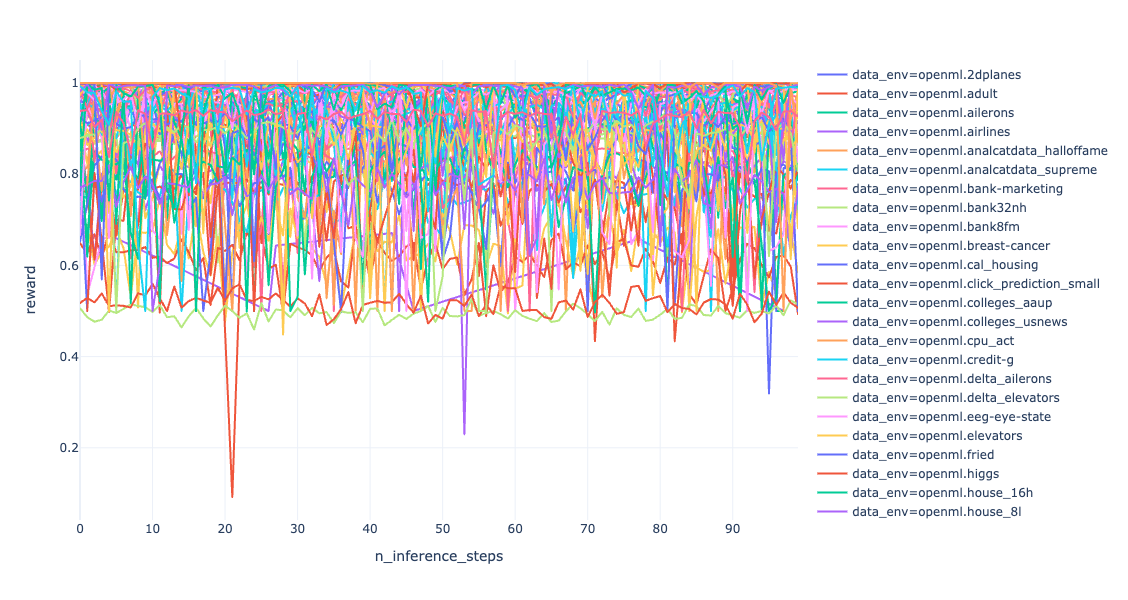

In [25]:
px.line(
    inference_results.query("data_env_partition == 'training'"),
    x="n_inference_steps",
    y="reward",
    template="plotly_white",
    color="data_env",
)

### Plot of Test Data Environment Validation Scores

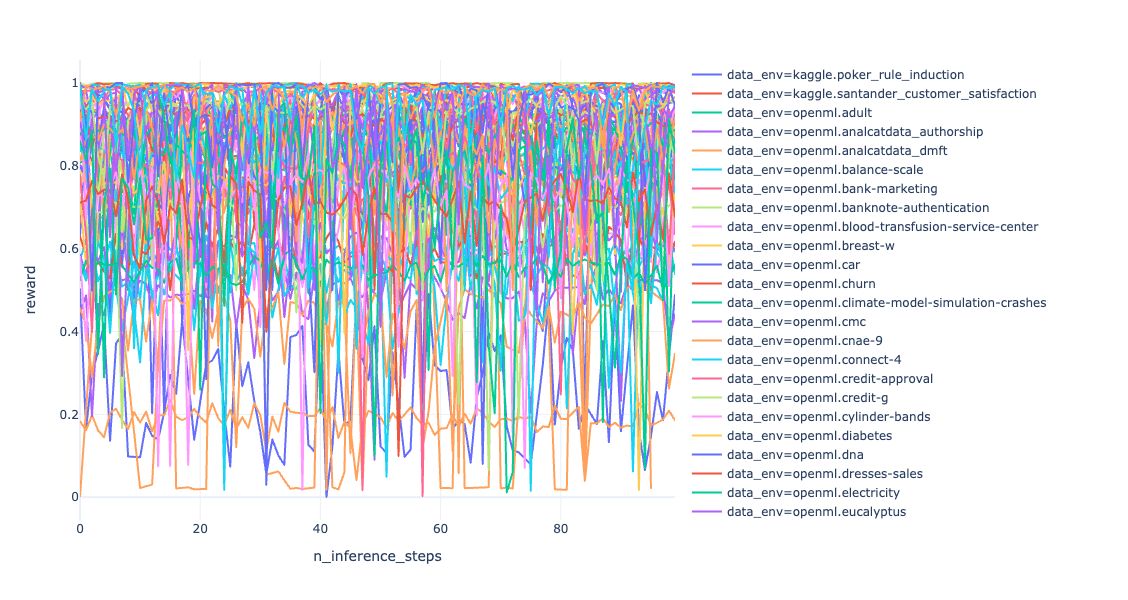

In [24]:
px.line(
    inference_results.query("data_env_partition == 'test'"),
    x="n_inference_steps",
    y="reward",
    template="plotly_white",
    color="data_env",
)

In [23]:
with pd.option_context("display.max_rows", 200):
    display(
        inference_results
        .groupby(["data_env_partition", "data_env"])
        .apply(lambda df: df.loc[df.validation_score.idxmax()])
        .reset_index(drop=True)
        .groupby("data_env_partition")
        .apply(lambda df: df.sort_values("validation_score"))
        .head()
    )

data_env  n_inference_steps  \
data_env_partition                                                             
test               4              openml.analcatdata_dmft                 15   
                   0          kaggle.poker_rule_induction                  0   
                   24  openml.first-order-theorem-proving                 92   
                   13                          openml.cmc                 86   
                   42                  openml.numerai28.6                 35   

                       is_valid  \
data_env_partition                
test               4       True   
                   0       True   
                   24      True   
                   13      True   
                   42      True   

                                                                     mlf  \
data_env_partition                                                         
test               4   SimpleImputer > OneHotEncoder > MinMaxScaler >...   
                   0   SimpleImputer > OneHotEncoder > MinMaxScaler >...   
                   24  SimpleImputer > OneHotEncoder > MinMaxScaler >...   
                   13  SimpleImputer > OneHotEncoder > MinMaxScaler >...   
                   42  SimpleImputer > OneHotEncoder > MinMaxScaler >...   

                                                                mlf_full  \
data_env_partition                                                         
test               4   {'SimpleImputer': ColumnTransformer(n_jobs=Non...   
                   0   {'SimpleImputer': ColumnTransformer(n_jobs=Non...   
                   24  {'SimpleImputer': ColumnTransformer(n_jobs=Non...   
                   13  {'SimpleImputer': ColumnTransformer(n_jobs=Non...   
                   42  {'SimpleImputer': ColumnTransformer(n_jobs=Non...   

                         reward    scorer            target_type  \
data_env_partition                                                 
test               4   0.234471  f1_macro  TargetType.MULTICLASS   
                   0   0.502079  f1_macro  TargetType.MULTICLASS   
                   24  0.511297  f1_macro  TargetType.MULTICLASS   
                   13  0.567958  f1_macro  TargetType.MULTICLASS   
                   42  0.595834   roc_auc      TargetType.BINARY   

                       validation_score data_env_partition  
data_env_partition                                          
test               4           0.234471               test  
                   0           0.502079               test  
                   24          0.511297               test  
                   13          0.567958               test  
                   42          0.595834               test